# Importing libraries

In [64]:
# Core libraries for data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Regular expression (used for cleaning mixed text/numeric columns like torque/mileage)
import re

# Preprocessing tools for handling numeric & categorical features
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Train/test split
from sklearn.model_selection import train_test_split

# Machine learning model (final chosen model)
from sklearn.ensemble import RandomForestRegressor

# Hyperparameter tuning utilities
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint  # for integer hyperparameter ranges

# Evaluation metrics for regression performance
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error, r2_score

# Load the dataset

In [65]:
# Load the dataset
df = pd.read_csv('/content/Car details v3.csv')
print("Dataset loaded successfully.")

Dataset loaded successfully.


## Data Overview


Shape of the DataFrame: (8128, 13)

Data types of each column:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB
None

Missing values information:
           Missing Count  Missing Percentage
torque               222  

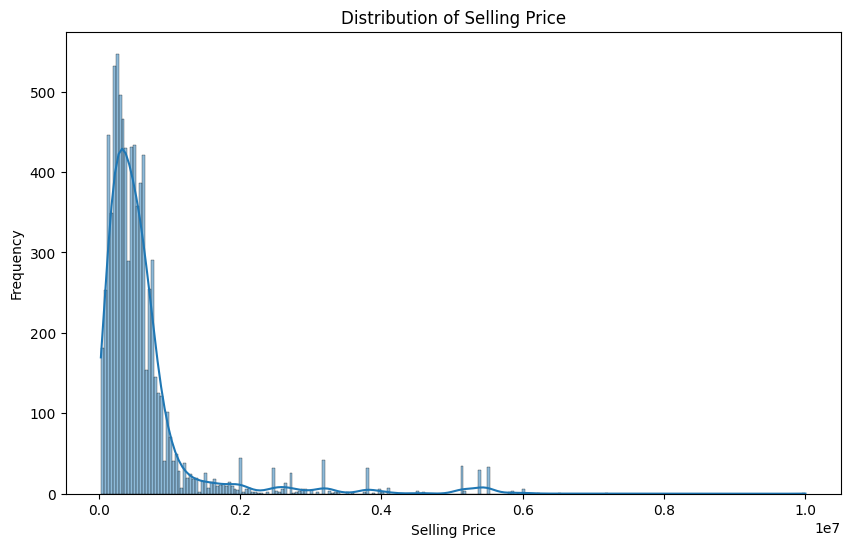


Shape of features (X): (8128, 12)
Shape of target (y): (8128,)
Data successfully split into features (X) and target (y).


In [66]:
# Display the number of rows and columns (shape)
print(f"\nShape of the DataFrame: {df.shape}")

# Show the data types of each column
print("\nData types of each column:")
print(df.info())

# Calculate and display missing values
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_info = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage
})
missing_info = missing_info[missing_info['Missing Count'] > 0].sort_values(by='Missing Percentage', ascending=False)
print("\nMissing values information:")
if missing_info.empty:
    print("No missing values in the dataset.")
else:
    print(missing_info)

# Analyze the distribution of the target variable 'selling_price'
print("\nDescriptive statistics for 'selling_price':")
print(df['selling_price'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(df['selling_price'], kde=True)
plt.title('Distribution of Selling Price')
plt.xlabel('Selling Price')
plt.ylabel('Frequency')
plt.show()

# Separate features (X) and target (y)
X = df.drop('selling_price', axis=1)
y = df['selling_price']

print(f"\nShape of features (X): {X.shape}")
print(f"Shape of target (y): {y.shape}")
print("Data successfully split into features (X) and target (y).")

## Exploratory Data Analysis

In [67]:
# Function to clean and convert columns to numeric
def clean_and_convert(df, column_name):
    if column_name == 'mileage':
        # Remove 'kmpl', 'km/kg', and any text after a space, then convert to numeric
        df[column_name] = df[column_name].astype(str).str.replace(r'kmpl|km/kg', '', regex=True).str.strip().str.split(' ').str[0]
    elif column_name == 'engine':
        # Remove 'CC' and any text after a space, then convert to numeric
        df[column_name] = df[column_name].astype(str).str.replace('CC', '', regex=False).str.strip().str.split(' ').str[0]
    elif column_name == 'max_power':
        # Remove 'bhp' and any text after a space, and '--', then convert to numeric
        df[column_name] = df[column_name].astype(str).str.replace('bhp', '', regex=False).str.replace('--', '', regex=False).str.strip().str.split(' ').str[0]
    elif column_name == 'torque':
        # Remove 'Nm', 'rpm' and all text including and after first '@' or starting from 'at', then convert to numeric
        df[column_name] = df[column_name].astype(str).str.replace(r'Nm|rpm', '', regex=True)
        df[column_name] = df[column_name].apply(lambda x: re.split(r'@|at', x)[0].strip() if isinstance(x, str) else x)

    df[column_name] = pd.to_numeric(df[column_name], errors='coerce')
    print(f"Column '{column_name}' cleaned and converted to numeric.")
    return df

# Apply cleaning and conversion to specified columns
columns_to_clean = ['mileage', 'engine', 'max_power', 'torque']
for col in columns_to_clean:
    df = clean_and_convert(df, col)

# Verify data types after conversion
print("\nData types after cleaning and conversion:")
print(df.info())

Column 'mileage' cleaned and converted to numeric.
Column 'engine' cleaned and converted to numeric.
Column 'max_power' cleaned and converted to numeric.
Column 'torque' cleaned and converted to numeric.

Data types after cleaning and conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   float64
 9   engine         7907 non-null   float64
 10  max_power      7912 non-null   float64
 11  torque         7528 non-null   float64
 12  seats          7907 non-n


--- Univariate Analysis: Numerical Features ---



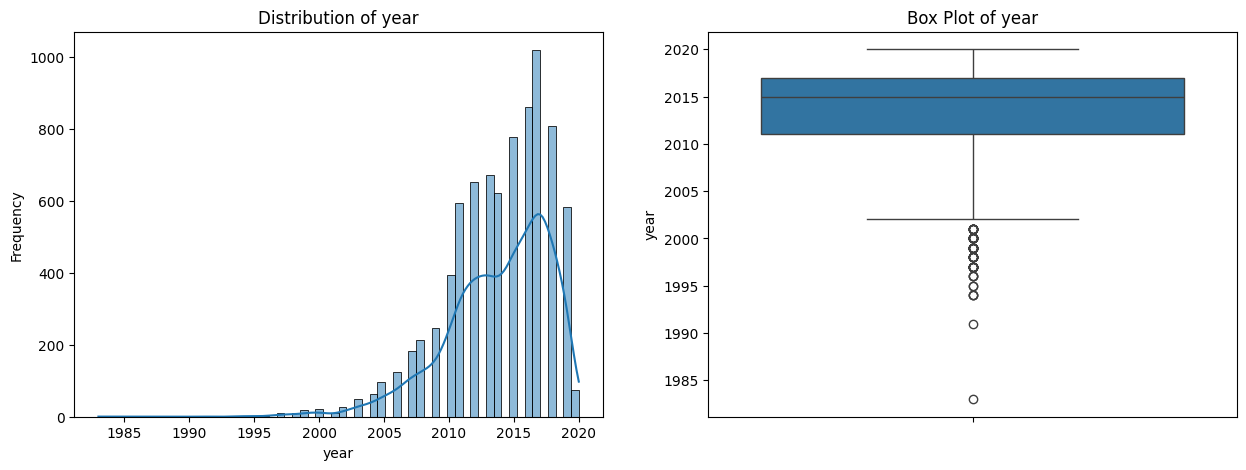


Insight for 'year':
  - Skewness: -1.07
  - Kurtosis: 1.71
  - Descriptive Statistics:
count    8128.000000
mean     2013.804011
std         4.044249
min      1983.000000
25%      2011.000000
50%      2015.000000
75%      2017.000000
max      2020.000000
  - The distribution is negatively skewed, indicating a longer tail to the left and potentially many higher values with some low outliers.
  - No missing values in this column.


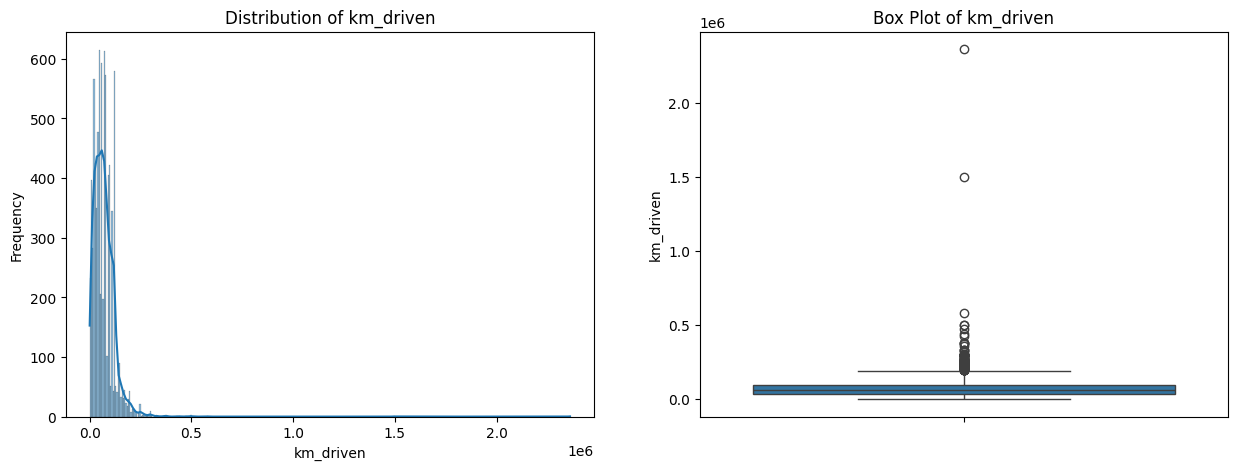


Insight for 'km_driven':
  - Skewness: 11.17
  - Kurtosis: 384.10
  - Descriptive Statistics:
count    8.128000e+03
mean     6.981951e+04
std      5.655055e+04
min      1.000000e+00
25%      3.500000e+04
50%      6.000000e+04
75%      9.800000e+04
max      2.360457e+06
  - The distribution is positively skewed, indicating a longer tail to the right and potentially many lower values with some high outliers.
  - No missing values in this column.


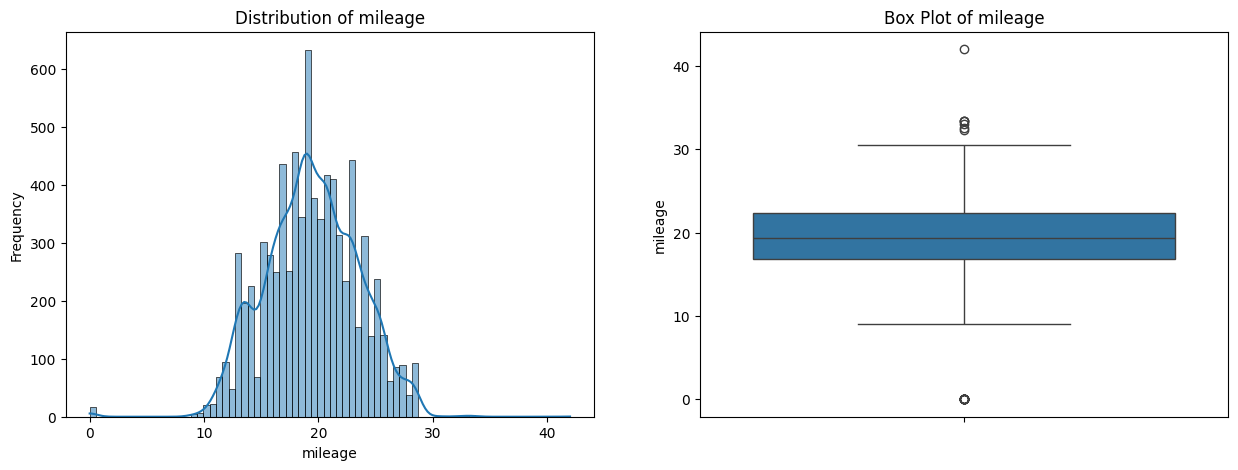


Insight for 'mileage':
  - Skewness: -0.14
  - Kurtosis: 0.57
  - Descriptive Statistics:
count    7907.000000
mean       19.418783
std         4.037145
min         0.000000
25%        16.780000
50%        19.300000
75%        22.320000
max        42.000000
  - The distribution appears relatively symmetrical.
  - Missing values are present in this column (Count: 221).


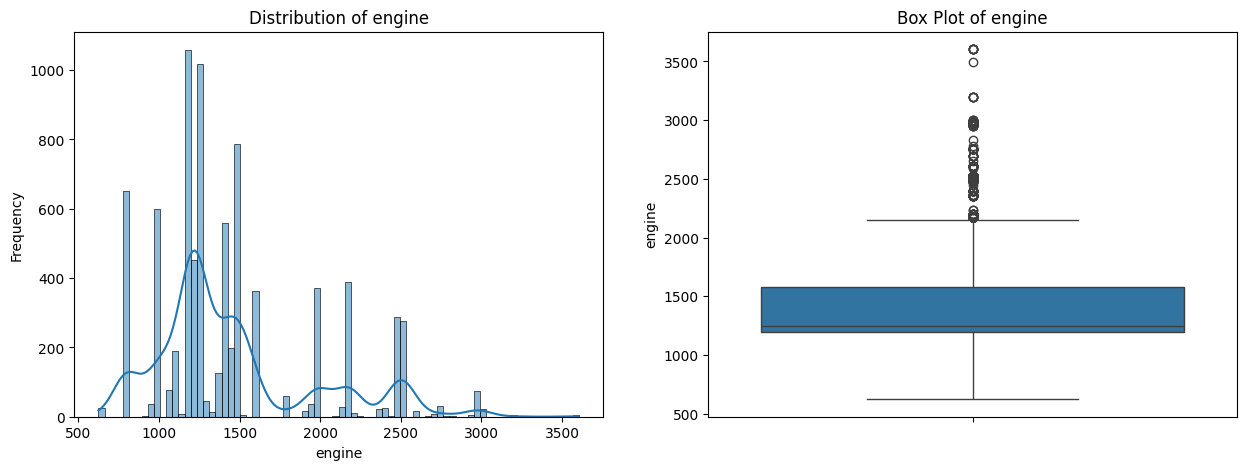


Insight for 'engine':
  - Skewness: 1.14
  - Kurtosis: 0.73
  - Descriptive Statistics:
count    7907.000000
mean     1458.625016
std       503.916303
min       624.000000
25%      1197.000000
50%      1248.000000
75%      1582.000000
max      3604.000000
  - The distribution is positively skewed, indicating a longer tail to the right and potentially many lower values with some high outliers.
  - Missing values are present in this column (Count: 221).


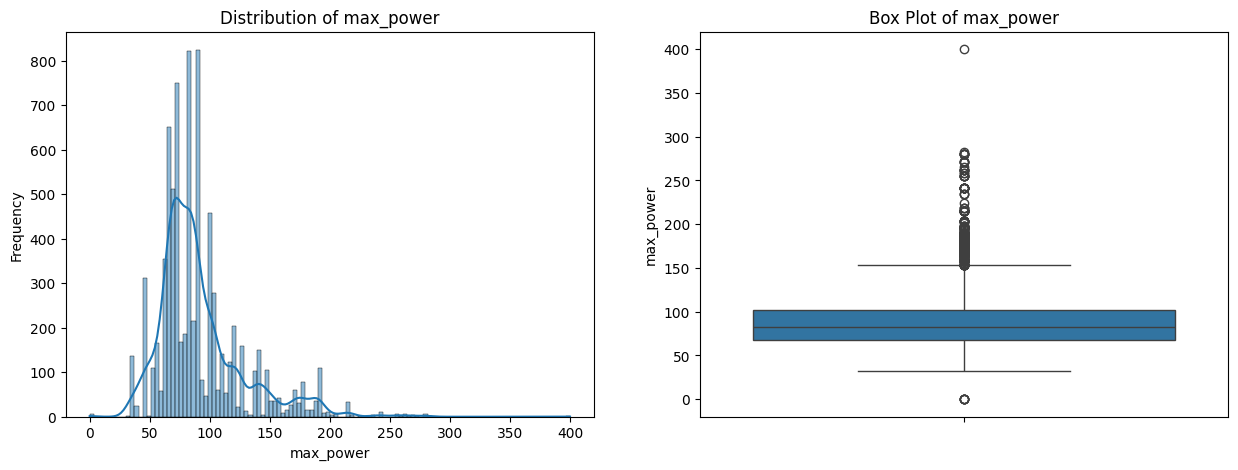


Insight for 'max_power':
  - Skewness: 1.62
  - Kurtosis: 3.78
  - Descriptive Statistics:
count    7912.000000
mean       91.517919
std        35.822499
min         0.000000
25%        68.050000
50%        82.000000
75%       102.000000
max       400.000000
  - The distribution is positively skewed, indicating a longer tail to the right and potentially many lower values with some high outliers.
  - Missing values are present in this column (Count: 216).


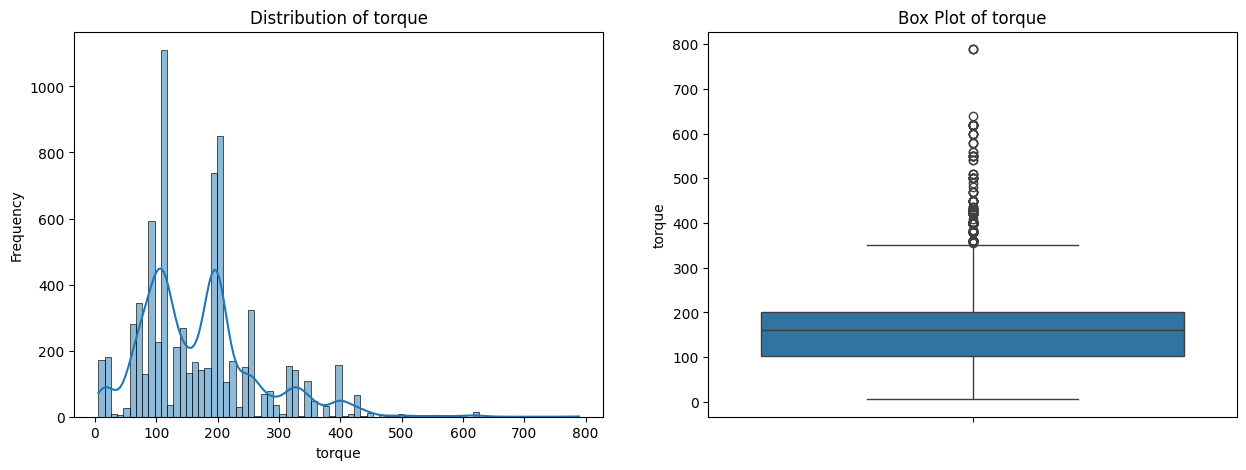


Insight for 'torque':
  - Skewness: 1.10
  - Kurtosis: 2.04
  - Descriptive Statistics:
count    7528.000000
mean      170.004980
std        96.752857
min         5.700000
25%       102.000000
50%       160.000000
75%       202.000000
max       789.000000
  - The distribution is positively skewed, indicating a longer tail to the right and potentially many lower values with some high outliers.
  - Missing values are present in this column (Count: 600).


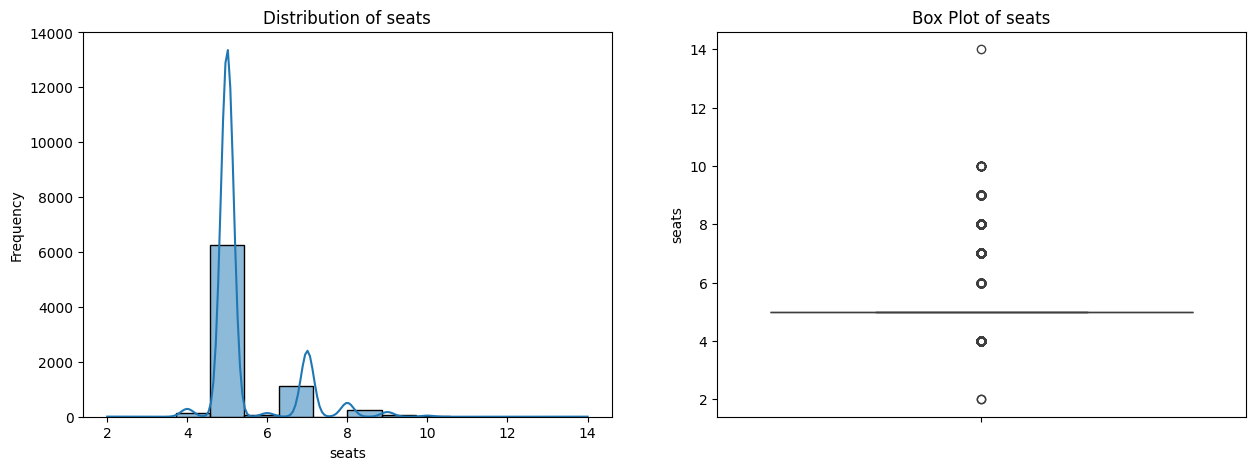


Insight for 'seats':
  - Skewness: 1.97
  - Kurtosis: 3.80
  - Descriptive Statistics:
count    7907.000000
mean        5.416719
std         0.959588
min         2.000000
25%         5.000000
50%         5.000000
75%         5.000000
max        14.000000
  - The distribution is positively skewed, indicating a longer tail to the right and potentially many lower values with some high outliers.
  - Missing values are present in this column (Count: 221).


In [ ]:
# Identify numerical columns for univariate analysis
numerical_cols = ['year', 'km_driven', 'mileage', 'engine', 'max_power', 'torque', 'seats']

print("\n--- Univariate Analysis: Numerical Features ---\n")

for col in numerical_cols:
    plt.figure(figsize=(15, 5))

    # Histogram and KDE plot
    plt.subplot(1, 2, 1)
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # Box plot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[col].dropna())
    plt.title(f'Box Plot of {col}')
    plt.ylabel(col)
    plt.show()

    # Insight for each numerical feature
    print(f"\nInsight for '{col}':")
    print(f"  - Skewness: {df[col].skew():.2f}")
    print(f"  - Kurtosis: {df[col].kurt():.2f}")
    print(f"  - Descriptive Statistics:\n{df[col].describe().to_string()}")
    if df[col].skew() > 0.5: # A common threshold for significant positive skew
        print("  - The distribution is positively skewed, indicating a longer tail to the right and potentially many lower values with some high outliers.")
    elif df[col].skew() < -0.5: # A common threshold for significant negative skew
        print("  - The distribution is negatively skewed, indicating a longer tail to the left and potentially many higher values with some low outliers.")
    else:
        print("  - The distribution appears relatively symmetrical.")
    if df[col].isnull().any():
        print(f"  - Missing values are present in this column (Count: {df[col].isnull().sum()}).")
    else:
        print("  - No missing values in this column.")



--- Univariate Analysis: Categorical Features ---



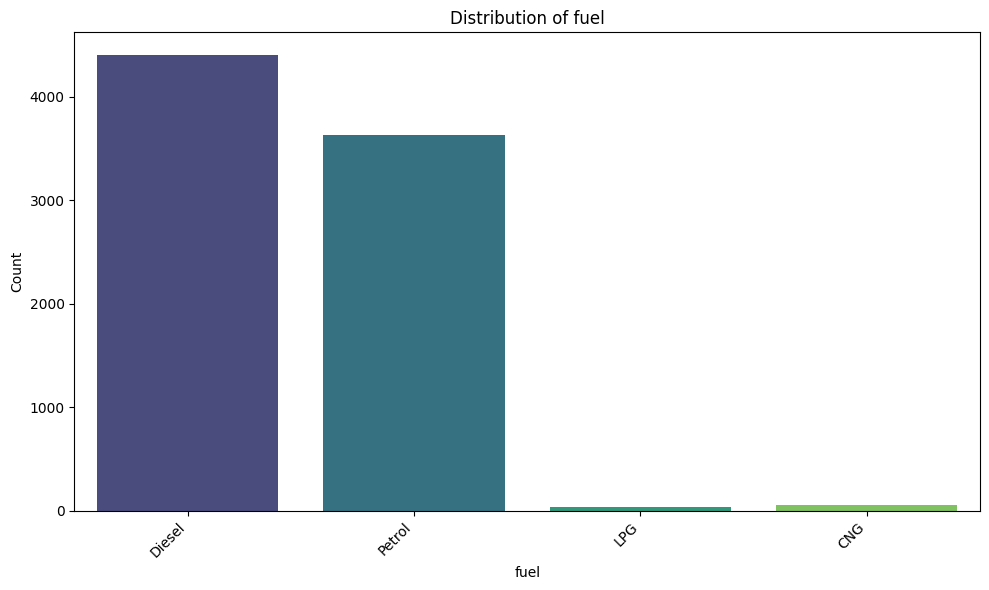


Insight for 'fuel':
  - Value Counts (Percentage):
fuel
Diesel    54.158465
Petrol    44.672736
CNG        0.701280
LPG        0.467520
  - The categories are relatively well-distributed or moderately imbalanced.


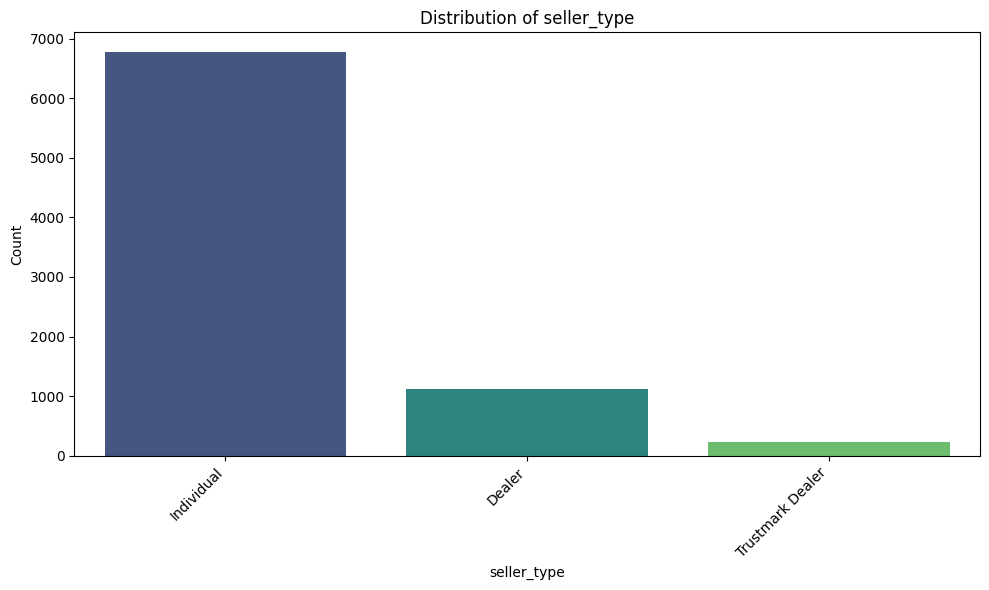


Insight for 'seller_type':
  - Value Counts (Percentage):
seller_type
Individual          83.243110
Dealer              13.853346
Trustmark Dealer     2.903543
  - This column is highly imbalanced, with 'Individual' being the dominant category.


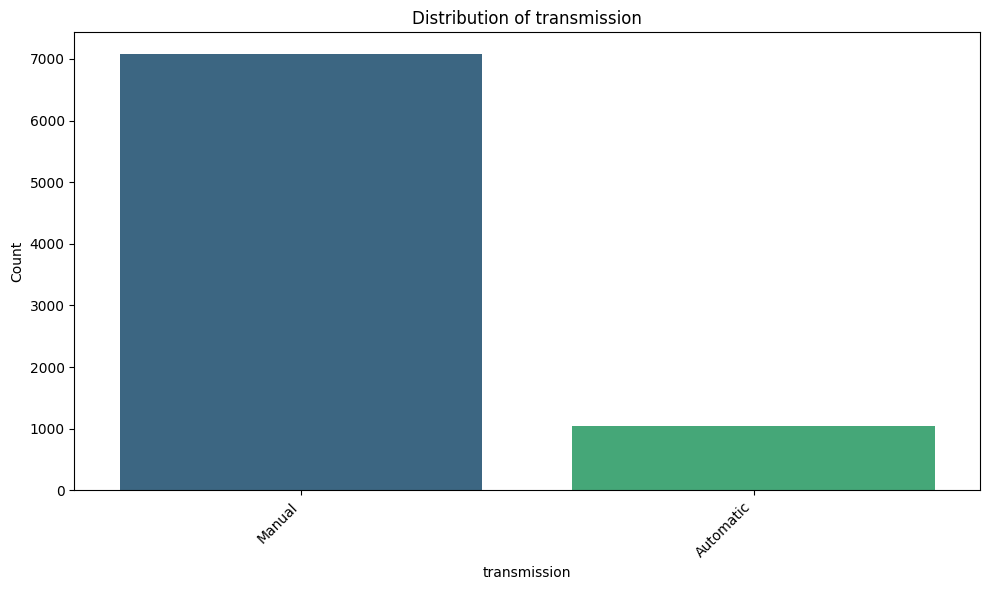


Insight for 'transmission':
  - Value Counts (Percentage):
transmission
Manual       87.081693
Automatic    12.918307
  - This column is highly imbalanced, with 'Manual' being the dominant category.


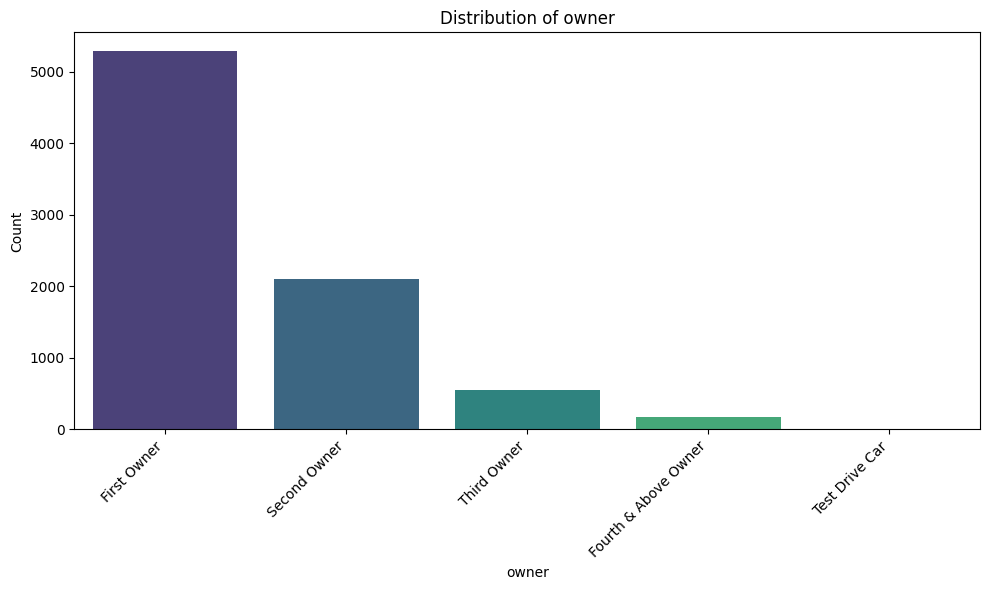


Insight for 'owner':
  - Value Counts (Percentage):
owner
First Owner             65.071358
Second Owner            25.898130
Third Owner              6.828248
Fourth & Above Owner     2.140748
Test Drive Car           0.061516
  - The categories are relatively well-distributed or moderately imbalanced.


In [ ]:
# Identify categorical columns for univariate analysis
categorical_cols = ['fuel', 'seller_type', 'transmission', 'owner']

print("\n--- Univariate Analysis: Categorical Features ---\n")

for col in categorical_cols:
    plt.figure(figsize=(10, 6))

    # Updated for seaborn v0.14+: assign hue to the same variable and hide legend
    sns.countplot(data=df, x=col, hue=col, palette='viridis', legend=False)

    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Insight for each categorical feature
    print(f"\nInsight for '{col}':")
    value_counts = df[col].value_counts(normalize=True) * 100
    print(f"  - Value Counts (Percentage):\n{value_counts.to_string()}")
    if value_counts.iloc[0] > 70:  # Arbitrary threshold for imbalance
        print(f"  - This column is highly imbalanced, with '{value_counts.index[0]}' being the dominant category.")
    else:
        print("  - The categories are relatively well-distributed or moderately imbalanced.")


--- Bivariate Analysis: Numerical Features vs. Selling Price ---



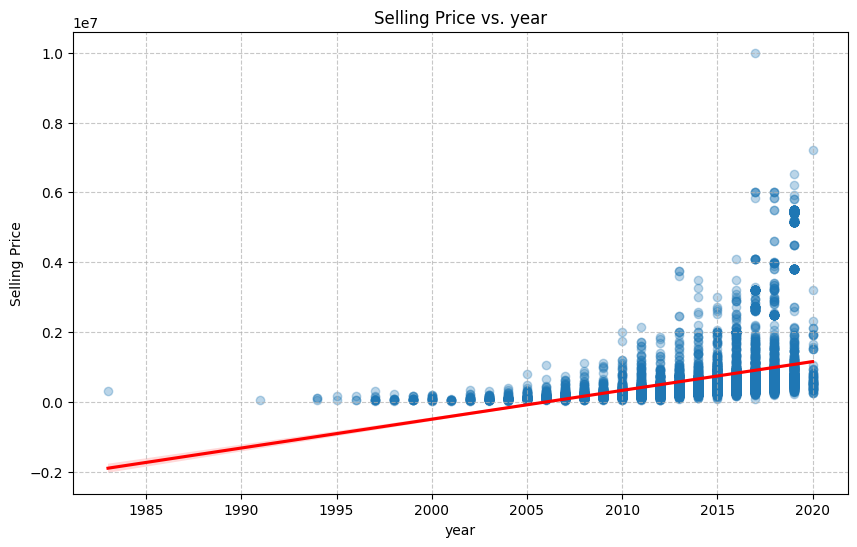


Insight for 'year' vs. 'selling_price':
  - Correlation with selling_price: 0.41
  - There is a moderate positive linear relationship, suggesting a noticeable but not strong tendency for selling price to increase with this feature.
  - Visual inspection suggests the presence of outliers, particularly in the upper range, which might influence the regression line.


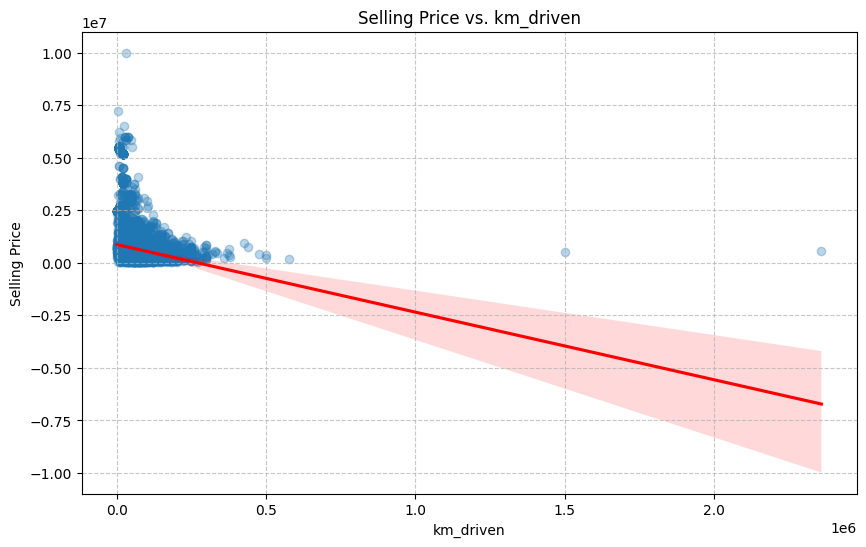


Insight for 'km_driven' vs. 'selling_price':
  - Correlation with selling_price: -0.23
  - There is a moderate negative linear relationship, suggesting a noticeable but not strong tendency for selling price to decrease with this feature.
  - Visual inspection suggests the presence of outliers, particularly in the upper range, which might influence the regression line.


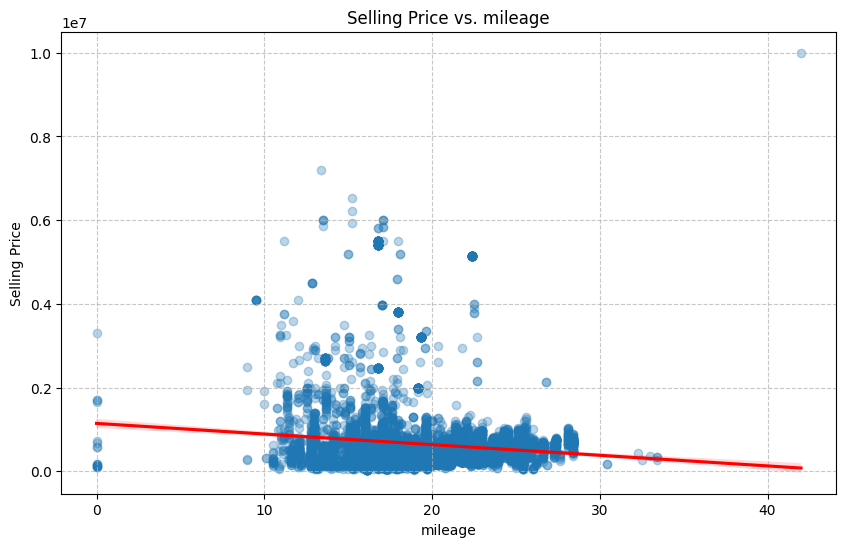


Insight for 'mileage' vs. 'selling_price':
  - Correlation with selling_price: -0.13
  - There appears to be a weak or no linear relationship with selling price.
  - Outlier detection is based on visual inspection due to missing values, some points are far from the main cluster.


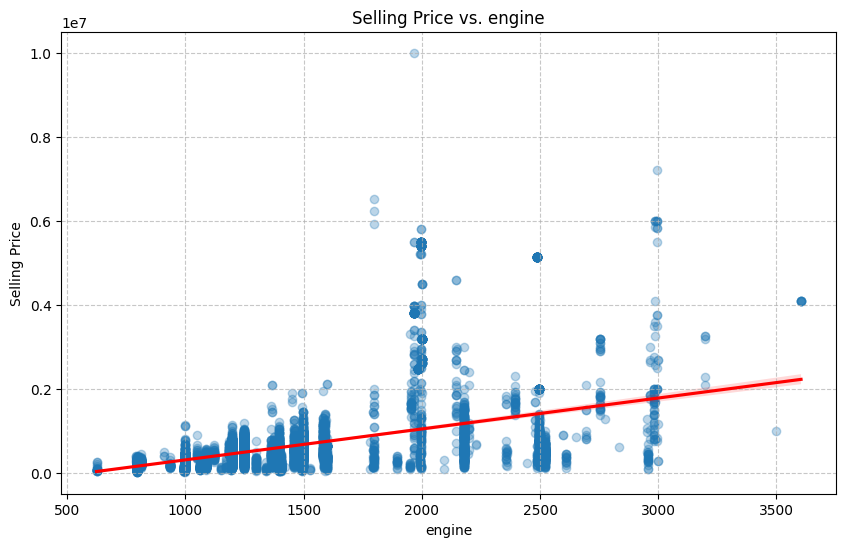


Insight for 'engine' vs. 'selling_price':
  - Correlation with selling_price: 0.46
  - There is a moderate positive linear relationship, suggesting a noticeable but not strong tendency for selling price to increase with this feature.
  - Outlier detection is based on visual inspection due to missing values, some points are far from the main cluster.


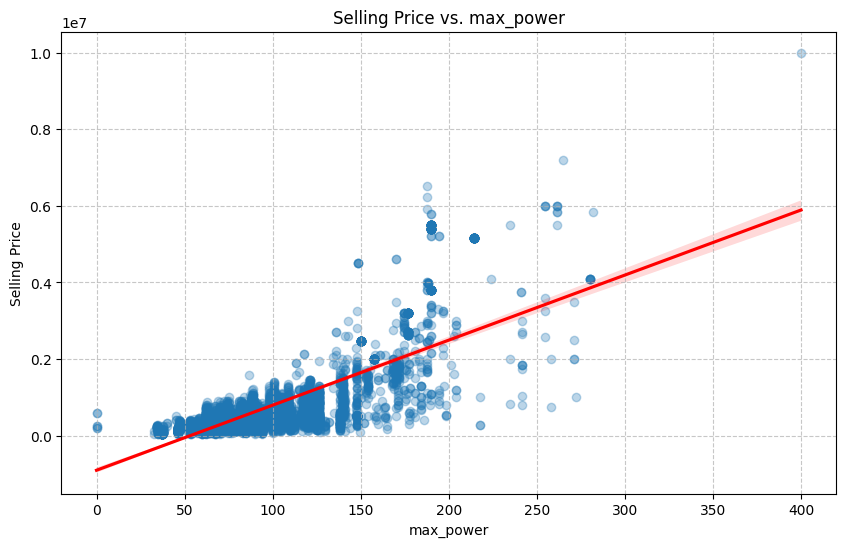


Insight for 'max_power' vs. 'selling_price':
  - Correlation with selling_price: 0.75
  - There is a strong positive linear relationship, indicating that as this feature increases, selling price tends to increase significantly.
  - Outlier detection is based on visual inspection due to missing values, some points are far from the main cluster.


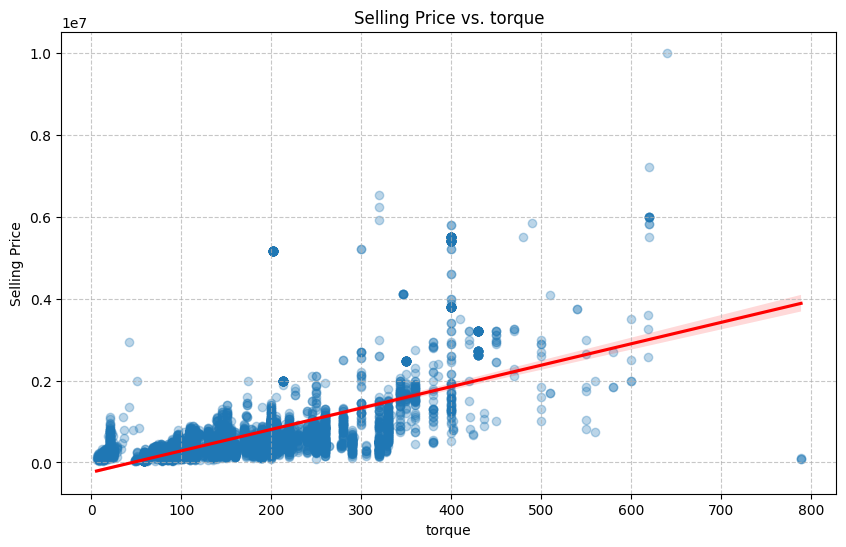


Insight for 'torque' vs. 'selling_price':
  - Correlation with selling_price: 0.62
  - There is a strong positive linear relationship, indicating that as this feature increases, selling price tends to increase significantly.
  - Outlier detection is based on visual inspection due to missing values, some points are far from the main cluster.


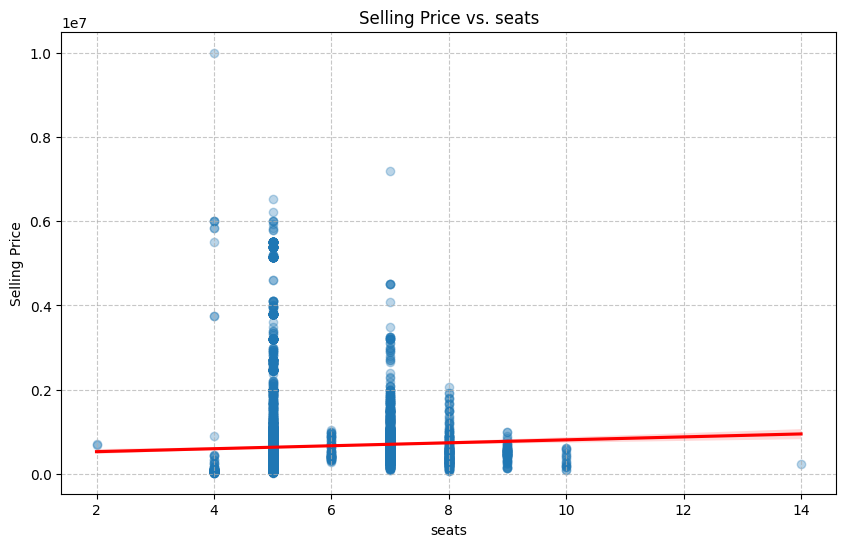


Insight for 'seats' vs. 'selling_price':
  - Correlation with selling_price: 0.04
  - There appears to be a weak or no linear relationship with selling price.
  - Outlier detection is based on visual inspection due to missing values, some points are far from the main cluster.


In [ ]:
# Identify numerical columns for bivariate analysis against selling_price
numerical_cols = ['year', 'km_driven', 'mileage', 'engine', 'max_power', 'torque', 'seats']

print("\n--- Bivariate Analysis: Numerical Features vs. Selling Price ---\n")

for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.regplot(data=df, x=col, y='selling_price', scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
    plt.title(f'Selling Price vs. {col}')
    plt.xlabel(col)
    plt.ylabel('Selling Price')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    # Insight for each numerical feature vs. selling_price
    print(f"\nInsight for '{col}' vs. 'selling_price':")
    correlation = df[col].corr(df['selling_price'])
    print(f"  - Correlation with selling_price: {correlation:.2f}")
    if correlation > 0.5:
        print("  - There is a strong positive linear relationship, indicating that as this feature increases, selling price tends to increase significantly.")
    elif correlation < -0.5:
        print("  - There is a strong negative linear relationship, indicating that as this feature increases, selling price tends to decrease significantly.")
    elif 0.2 < correlation <= 0.5:
        print("  - There is a moderate positive linear relationship, suggesting a noticeable but not strong tendency for selling price to increase with this feature.")
    elif -0.5 <= correlation < -0.2:
        print("  - There is a moderate negative linear relationship, suggesting a noticeable but not strong tendency for selling price to decrease with this feature.")
    else:
        print("  - There appears to be a weak or no linear relationship with selling price.")

    # Outlier detection visual comment
    if df[col].isnull().sum() == 0:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers_count = df[(df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))].shape[0]
        if outliers_count > 0:
            print(f"  - Visual inspection suggests the presence of outliers, particularly in the upper range, which might influence the regression line.")
        else:
            print(f"  - No significant outliers are visibly present.")
    else:
        print(f"  - Outlier detection is based on visual inspection due to missing values, some points are far from the main cluster.")



--- Bivariate Analysis: Categorical Features vs. Selling Price ---



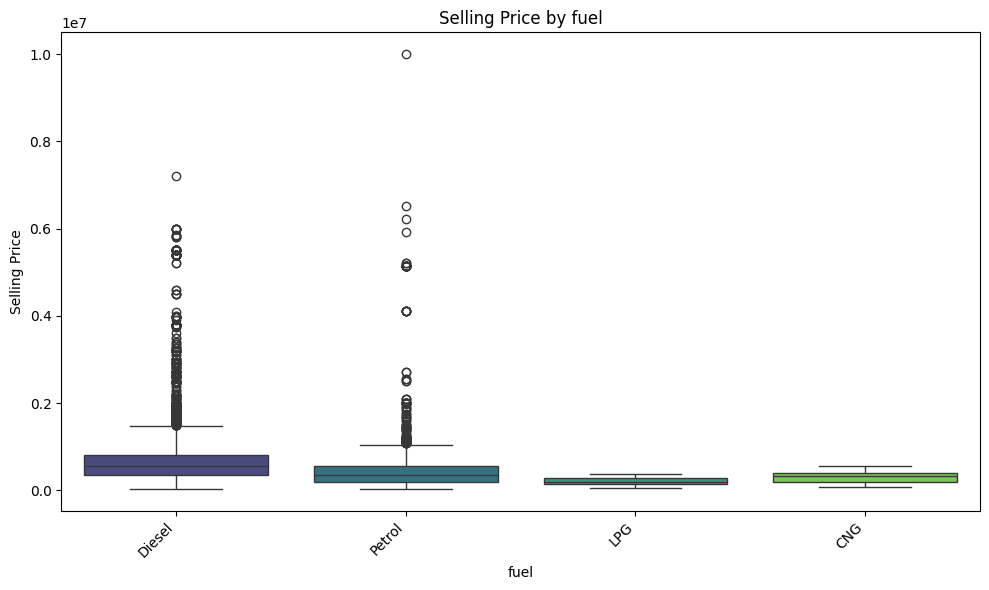


Insight for 'fuel' vs. 'selling_price':
  - Median selling price by category:
fuel
Diesel    550000.0
Petrol    345000.0
CNG       320000.0
LPG       195500.0
  - Observe how the median selling price and its spread vary across different categories. Some categories clearly show higher or lower average selling prices, indicating their influence on the target variable.


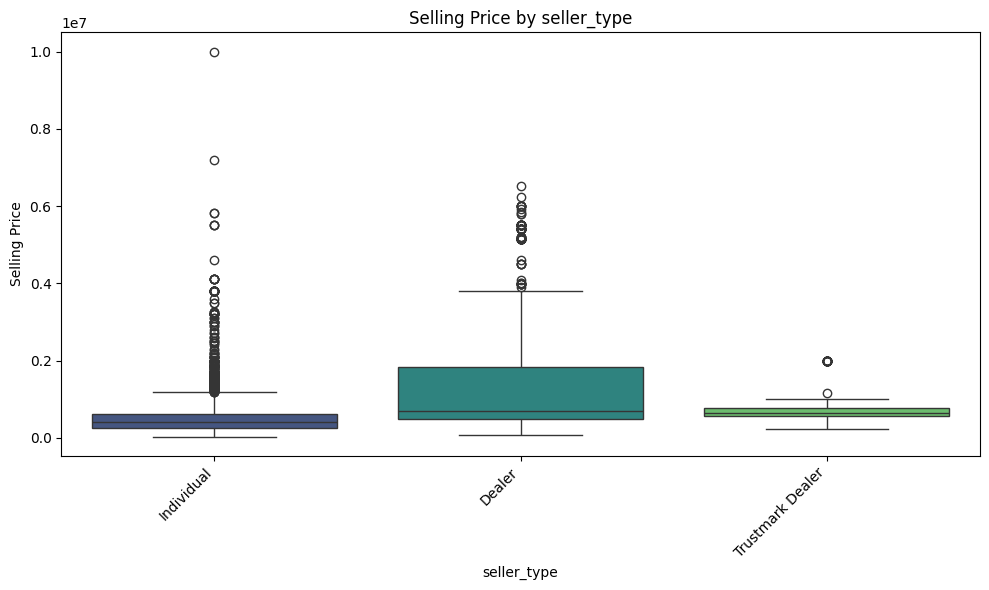


Insight for 'seller_type' vs. 'selling_price':
  - Median selling price by category:
seller_type
Dealer              690000.0
Trustmark Dealer    650000.0
Individual          400000.0
  - Observe how the median selling price and its spread vary across different categories. Some categories clearly show higher or lower average selling prices, indicating their influence on the target variable.


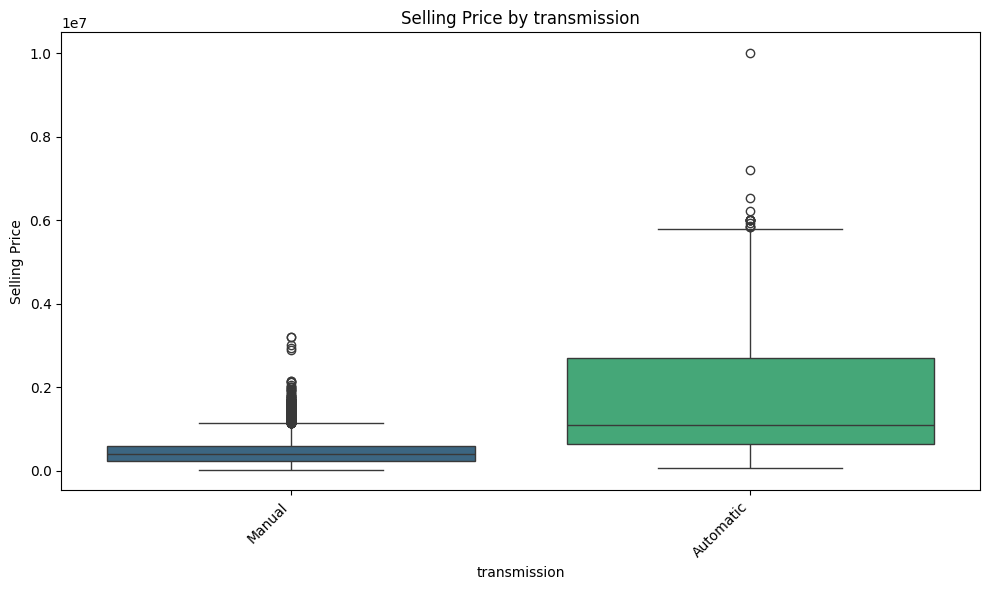


Insight for 'transmission' vs. 'selling_price':
  - Median selling price by category:
transmission
Automatic    1100000.0
Manual        400000.0
  - Observe how the median selling price and its spread vary across different categories. Some categories clearly show higher or lower average selling prices, indicating their influence on the target variable.


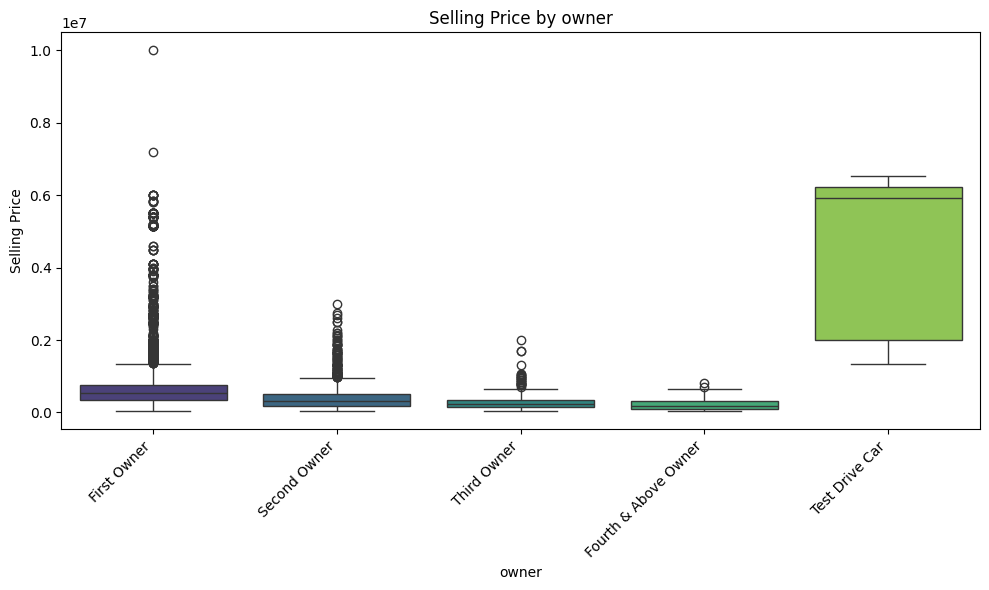


Insight for 'owner' vs. 'selling_price':
  - Median selling price by category:
owner
Test Drive Car          5923000.0
First Owner              550000.0
Second Owner             310000.0
Third Owner              225000.0
Fourth & Above Owner     170000.0
  - Observe how the median selling price and its spread vary across different categories. Some categories clearly show higher or lower average selling prices, indicating their influence on the target variable.


In [ ]:
# Identify categorical columns for bivariate analysis against selling_price
categorical_cols = ['fuel', 'seller_type', 'transmission', 'owner']

print("\n--- Bivariate Analysis: Categorical Features vs. Selling Price ---\n")

for col in categorical_cols:
    plt.figure(figsize=(10, 6))

    # Updated seaborn syntax: assign hue=col when using palette, disable legend
    sns.boxplot(data=df, x=col, y='selling_price', hue=col, palette='viridis', legend=False)

    plt.title(f'Selling Price by {col}')
    plt.xlabel(col)
    plt.ylabel('Selling Price')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Insight for each categorical feature vs. selling_price
    print(f"\nInsight for '{col}' vs. 'selling_price':")
    median_prices = df.groupby(col)['selling_price'].median().sort_values(ascending=False)
    print(f"  - Median selling price by category:\n{median_prices.to_string()}")
    print("  - Observe how the median selling price and its spread vary across different categories. Some categories clearly show higher or lower average selling prices, indicating their influence on the target variable.")


--- Correlation Analysis: Numerical Features ---



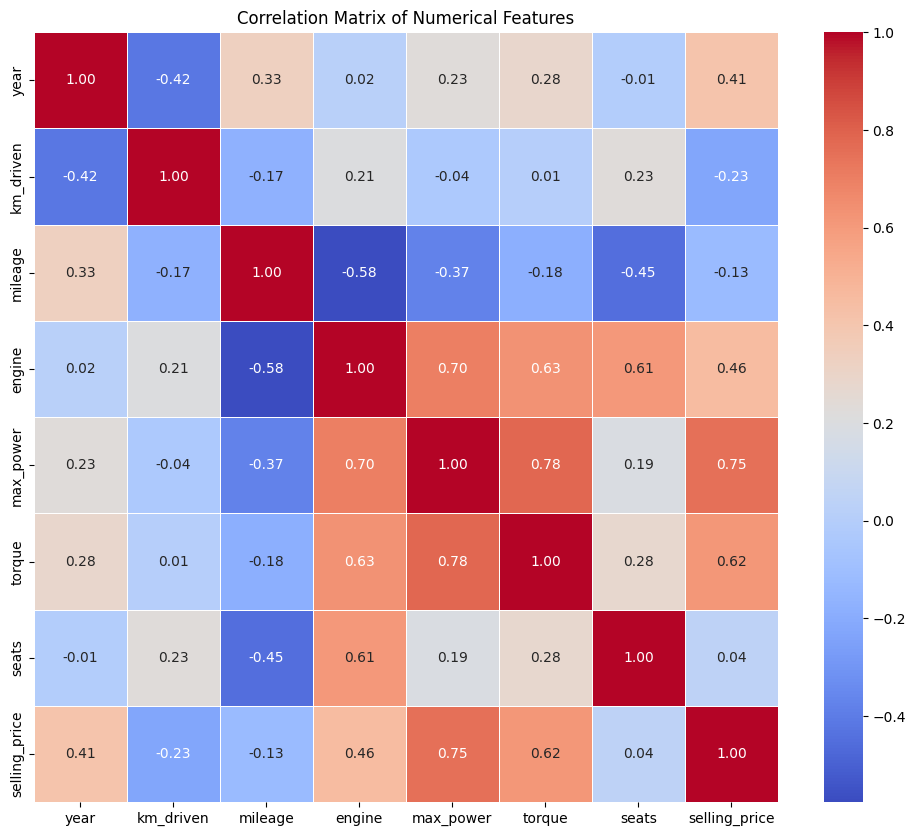


Insight into Correlation Matrix:
  - Strongest positive correlations with 'selling_price':
selling_price    1.000000
max_power        0.748489
torque           0.618206

  - Strongest negative correlations with 'selling_price':
km_driven   -0.225534
mileage     -0.126054
seats        0.041358
  - Observe how features like 'max_power' and 'torque' show strong positive correlations with 'selling_price', indicating they are significant drivers of car prices. 'km_driven' shows a moderate negative correlation. Pay attention to multicollinearity among independent variables as well, although less critical for simple EDA.


In [ ]:
# Identify numerical columns for correlation analysis
numerical_cols = ['year', 'km_driven', 'mileage', 'engine', 'max_power', 'torque', 'seats', 'selling_price']

print("\n--- Correlation Analysis: Numerical Features ---\n")

# Calculate the correlation matrix
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Insight into correlations
print("\nInsight into Correlation Matrix:")
print("  - Strongest positive correlations with 'selling_price':")
print(correlation_matrix['selling_price'].sort_values(ascending=False).head(3).to_string())
print("\n  - Strongest negative correlations with 'selling_price':")
print(correlation_matrix['selling_price'].sort_values(ascending=True).head(3).to_string())
print("  - Observe how features like 'max_power' and 'torque' show strong positive correlations with 'selling_price', indicating they are significant drivers of car prices. 'km_driven' shows a moderate negative correlation. Pay attention to multicollinearity among independent variables as well, although less critical for simple EDA.")


--- Missing Value Summary (Updated) ---
           Missing Count  Missing Percentage
torque               600            7.381890
mileage              221            2.718996
engine               221            2.718996
seats                221            2.718996
max_power            216            2.657480


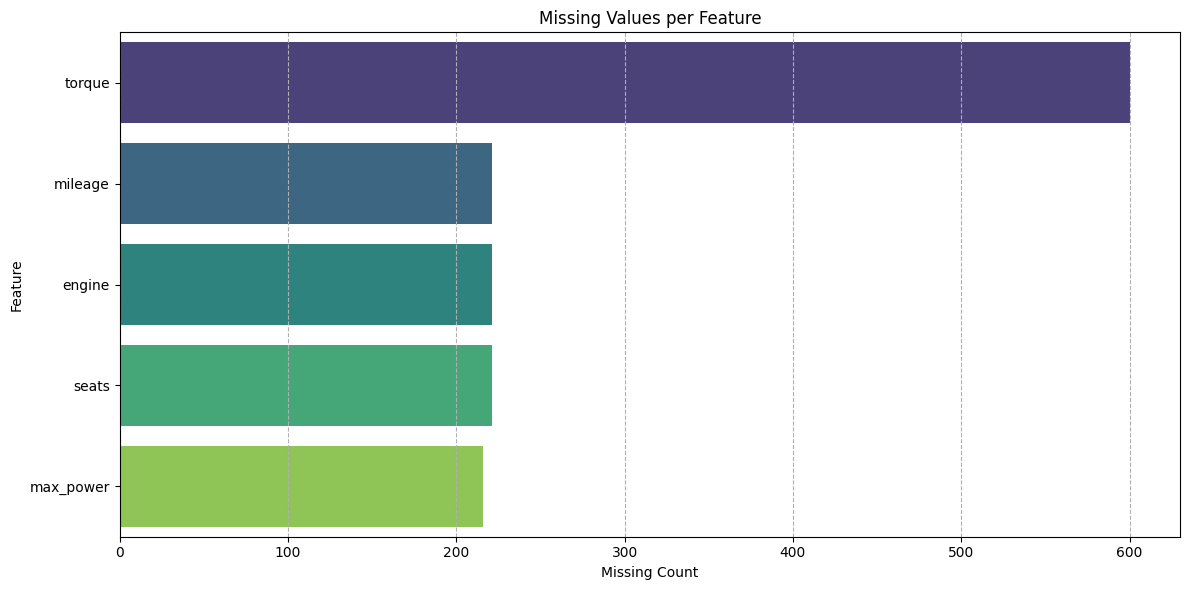


Insights:
  - The bar chart shows exactly which features still contain missing values and how many.
  - High-missing columns likely require imputation or special cleaning.
  - Missing patterns across 'mileage', 'engine', 'max_power', 'torque', and 'seats' are common in scraped car datasets.
  - These values may be missing together due to incomplete car listings.


In [ ]:
print("\n--- Missing Value Summary (Updated) ---")

# Recalculate missing values after cleaning
missing_counts = df.isnull().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)

missing_percentages = (missing_counts / len(df)) * 100

missing_info_re_evaluated = pd.DataFrame({
    "Missing Count": missing_counts,
    "Missing Percentage": missing_percentages
})

# If no missing values, print message and stop
if missing_info_re_evaluated.empty:
    print("No missing values remain in the dataset.")
else:
    print(missing_info_re_evaluated)

    # Clean and easy-to-read bar plot (Seaborn 0.14+ compatible)
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x=missing_counts.values,
        y=missing_counts.index,
        palette="viridis",
        hue=missing_counts.index,
        legend=False
    )
    plt.title("Missing Values per Feature")
    plt.xlabel("Missing Count")
    plt.ylabel("Feature")
    plt.grid(axis='x', linestyle='--')
    plt.tight_layout()
    plt.show()

    # Insight block
    print("\nInsights:")
    print("  - The bar chart shows exactly which features still contain missing values and how many.")
    print("  - High-missing columns likely require imputation or special cleaning.")
    print("  - Missing patterns across 'mileage', 'engine', 'max_power', 'torque', and 'seats' are common in scraped car datasets.")
    print("  - These values may be missing together due to incomplete car listings.")

## Preprocessing

In [ ]:
# Re-create X and y from the cleaned df
X = df.drop('selling_price', axis=1)
y = df['selling_price']

# Drop the 'name' column from X as per instructions
X_processed = X.drop('name', axis=1)

# Correctly identify numerical and categorical features from X_processed
# Based on the df.info() from previous steps, mileage, engine, max_power, torque, and seats are float64
numerical_features = X_processed.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_processed.select_dtypes(include='object').columns.tolist()

print(f"Original features in X: {X.columns.tolist()}\n")
print(f"Features after dropping 'name': {X_processed.columns.tolist()}\n")
print(f"Numerical Features identified: {numerical_features}")
print(f"Categorical Features identified: {categorical_features}")

# Define preprocessing pipelines
# Numerical pipeline: impute with median
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Categorical pipeline: impute with most frequent, then one-hot encode
categoric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a ColumnTransformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categoric_transformer, categorical_features)
    ],
    remainder='passthrough' # 'name' was dropped, no other columns are expected to be passed through
)

# Fit and transform the features
X_transformed = preprocessor.fit_transform(X_processed)

# Get feature names after one-hot encoding for the categorical columns
# Access the OneHotEncoder within the 'cat' pipeline
onehot_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(onehot_feature_names)

# Convert the transformed array back to a DataFrame
X_transformed_df = pd.DataFrame(X_transformed, columns=all_feature_names)

print(f"\nShape of X_processed before transformation: {X_processed.shape}")
print(f"Shape of X_transformed after transformation: {X_transformed_df.shape}")

# Verify no missing values remain
missing_after_preprocessing = X_transformed_df.isnull().sum().sum()
print(f"\nTotal missing values after preprocessing: {missing_after_preprocessing}")

if missing_after_preprocessing == 0:
    print("Preprocessing successful: No missing values remain in the transformed data.")
else:
    print("Warning: Missing values still exist after preprocessing.")

print("\nFirst 5 rows of the preprocessed data (X_transformed_df):")
print(X_transformed_df.head())

Original features in X: ['name', 'year', 'km_driven', 'fuel', 'seller_type', 'transmission', 'owner', 'mileage', 'engine', 'max_power', 'torque', 'seats']

Features after dropping 'name': ['year', 'km_driven', 'fuel', 'seller_type', 'transmission', 'owner', 'mileage', 'engine', 'max_power', 'torque', 'seats']

Numerical Features identified: ['year', 'km_driven', 'mileage', 'engine', 'max_power', 'torque', 'seats']
Categorical Features identified: ['fuel', 'seller_type', 'transmission', 'owner']

Shape of X_processed before transformation: (8128, 11)
Shape of X_transformed after transformation: (8128, 21)

Total missing values after preprocessing: 0
Preprocessing successful: No missing values remain in the transformed data.

First 5 rows of the preprocessed data (X_transformed_df):
     year  km_driven  mileage  engine  max_power  torque  seats  fuel_CNG  \
0  2014.0   145500.0    23.40  1248.0      74.00   190.0    5.0       0.0   
1  2014.0   120000.0    21.14  1498.0     103.52   250

## Train/Test Split

In [ ]:
# Split the preprocessed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed_df, y, test_size=0.20, random_state=42)

print("Data split into training and testing sets.")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Data split into training and testing sets.
Shape of X_train: (6502, 21)
Shape of X_test: (1626, 21)
Shape of y_train: (6502,)
Shape of y_test: (1626,)


## Hyperparameter Tuning (Random Forest)

In [ ]:
#  Define the hyperparameter search space for Random Forest tuning
param_dist = {
    'n_estimators': randint(100, 500),
    'max_features': ['sqrt', 'log2', None],
    'max_depth': randint(10, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10)
}

#  Create a custom scoring function for negative RMSE
def neg_rmse_scorer(y_true, y_pred):
    return -np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(neg_rmse_scorer, greater_is_better=True)

print("Starting RandomizedSearchCV for RandomForestRegressor...")

#  Initialize RandomizedSearchCV
rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50, # Number of parameter settings that are sampled
    cv=5, # 5-fold cross-validation
    scoring=rmse_scorer, # Optimize for negative RMSE (maximize it)
    random_state=42,
    verbose=2,
    n_jobs=-1 # Use all available cores
)

#  Fit RandomizedSearchCV to the training data
random_search.fit(X_train, y_train)

#  Print the best hyperparameters
print(f"\nBest Hyperparameters found: {random_search.best_params_}")

#  Extract the best model
best_rf_model = random_search.best_estimator_

#  Evaluate the best model on the test set
y_pred_tuned = best_rf_model.predict(X_test)

mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
r2_tuned = r2_score(y_test, y_pred_tuned)

print("\n--- Tuned RandomForestRegressor Performance on Test Set ---")
print(f"Mean Absolute Error (MAE): {mae_tuned:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_tuned:.2f}")
print(f"R-squared (R²): {r2_tuned:.2f}")

print("Hyperparameter tuning completed and best model evaluated.")

Starting RandomizedSearchCV for RandomForestRegressor...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best Hyperparameters found: {'max_depth': 38, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 108}

--- Tuned RandomForestRegressor Performance on Test Set ---
Mean Absolute Error (MAE): 70838.91
Root Mean Squared Error (RMSE): 142771.54
R-squared (R²): 0.97
Hyperparameter tuning completed and best model evaluated.


## Model Diagnostics

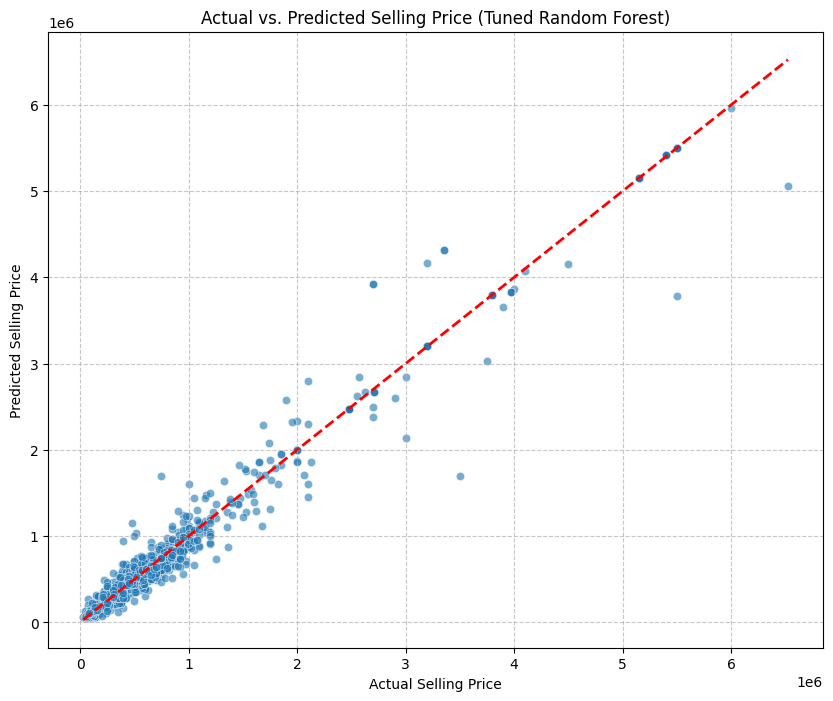

In [ ]:
#  Create a scatter plot of Actual vs. Predicted values
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_test, y=y_pred_tuned, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Diagonal line for perfect predictions
plt.title('Actual vs. Predicted Selling Price (Tuned Random Forest)')
plt.xlabel('Actual Selling Price')
plt.ylabel('Predicted Selling Price')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


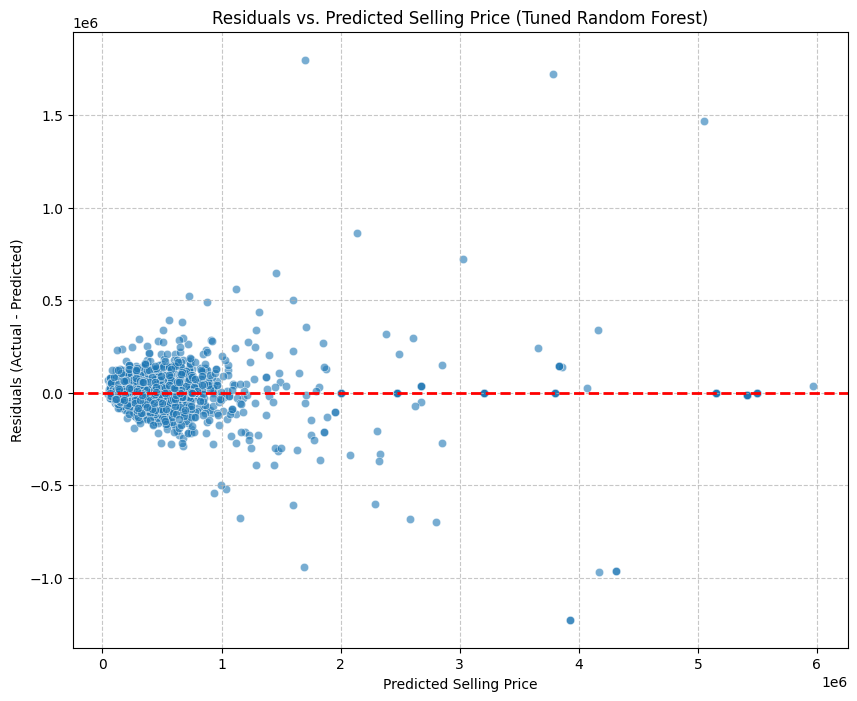

In [ ]:
#  Calculate the residuals
residuals = y_test - y_pred_tuned

#  Create a scatter plot of Residuals vs. Predicted values
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_pred_tuned, y=residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', lw=2) # Horizontal line at y=0
plt.title('Residuals vs. Predicted Selling Price (Tuned Random Forest)')
plt.xlabel('Predicted Selling Price')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### Diagnostic Plots Commentary

**1. Actual vs. Predicted Selling Price Plot:**

-   **Observations:** The scatter plot of actual vs. predicted selling prices shows that the points largely cluster around the diagonal red dashed line, especially for lower and moderate selling prices. This indicates a strong positive correlation between the actual and predicted values, suggesting the tuned Random Forest model is performing well in predicting the selling price.
-   **Accuracy:** The close alignment to the diagonal line implies good predictive accuracy for a majority of the data points.
-   **Potential Issues:** For very high selling prices (e.g., above 5,000,000), there appears to be some dispersion, with predictions sometimes underestimating the actual values. This could indicate that the model struggles a bit more with accurately predicting the prices of very expensive cars, possibly due to fewer data points in this range or higher variability.

**2. Residuals vs. Predicted Selling Price Plot:**

-   **Observations:** The residuals plot shows the difference between actual and predicted values plotted against the predicted values. Ideally, residuals should be randomly scattered around the horizontal line at zero, with no discernible pattern. In our plot, the residuals generally appear centered around zero, which is a good sign indicating that the model's predictions are unbiased on average.
-   **Homoscedasticity:** There doesn't appear to be a severe case of heteroscedasticity (where the spread of residuals changes across the range of predicted values). The spread seems relatively consistent for most predicted values, although there might be a slight increase in variance for higher predicted selling prices.
-   **Outliers:** Some residual points are far from the zero line, indicating instances where the model made significantly larger errors (both over- and under-predictions). These could be outliers in the data or cases where the model struggled to capture the underlying relationships.
-   **Bias:** The lack of a clear U-shape or inverted U-shape suggests that the model is not systematically over- or under-predicting across the range of predicted values.

**Overall Model Performance:**

The diagnostic plots confirm the strong performance of the tuned Random Forest model, as suggested by the high R² and low RMSE metrics. The model effectively captures the variance in selling prices, and its predictions are generally accurate and unbiased. While there's a slight tendency for larger errors at the extreme high end of selling prices and the presence of some individual large errors (outliers), these are common challenges in regression tasks. Further investigation into these high-value cars or large residual points could potentially lead to further model improvements, perhaps by gathering more data for high-end cars or incorporating additional relevant features.

## Feature Importance

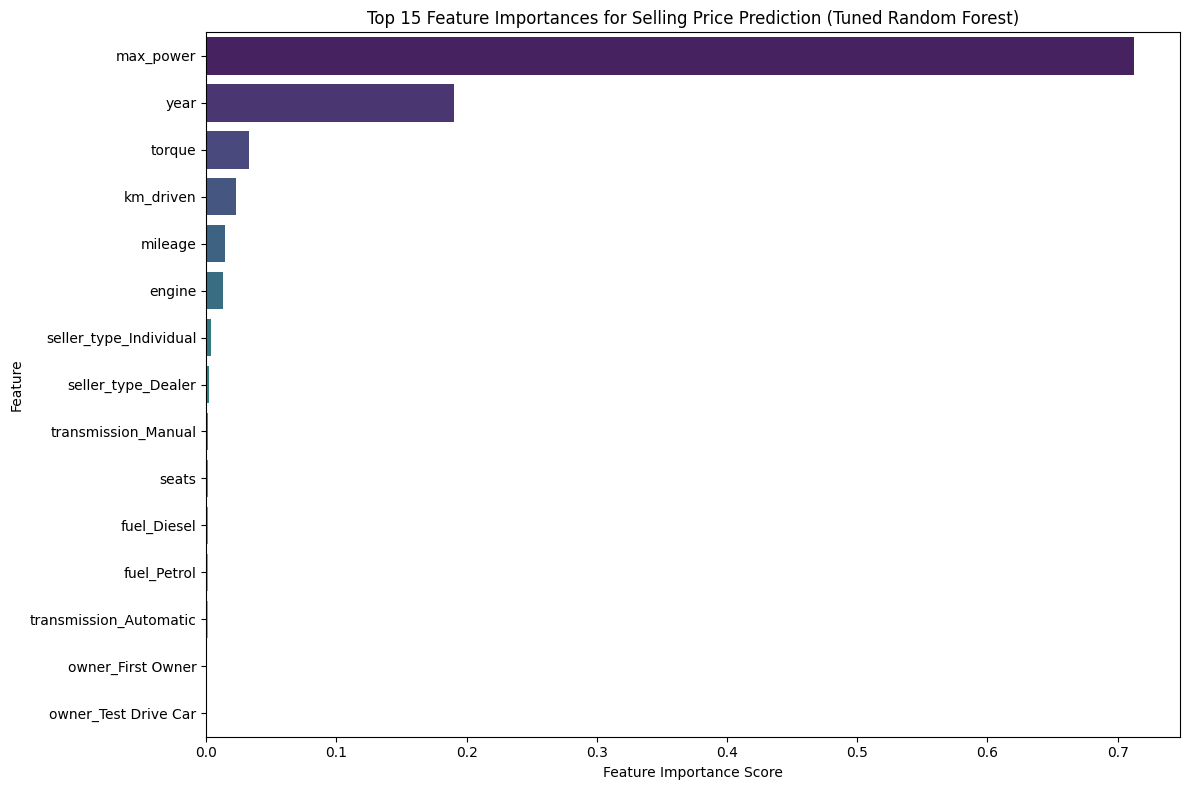


--- Feature Importance Commentary ---
The bar chart above displays the most influential features as determined by the tuned Random Forest model.
- You can clearly see which features impact selling price the most.
- Typically, performance-related features such as 'max_power', 'engine', 'year', and 'torque' rank highest.
- One-hot encoded categorical features (e.g., 'fuel_Diesel', 'transmission_Automatic') also show measurable influence.
- Understanding these importances helps guide feature engineering, data collection priorities, and business interpretation.


In [ ]:
# Extract feature importances from the tuned Random Forest model
feature_importances = best_rf_model.feature_importances_

# Create a Pandas Series mapping feature names to importance scores
feature_importance_series = pd.Series(feature_importances, index=all_feature_names)

# Sort feature importances in descending order
sorted_feature_importances = feature_importance_series.sort_values(ascending=False)

# Define the number of top features to plot
num_top_features = 15

# Create a horizontal bar plot for the top N most important features
plt.figure(figsize=(12, 8))
sns.barplot(
    x=sorted_feature_importances.head(num_top_features).values,
    y=sorted_feature_importances.head(num_top_features).index,
    palette='viridis',
    hue=sorted_feature_importances.head(num_top_features).index,
    legend=False
)
plt.title(f'Top {num_top_features} Feature Importances for Selling Price Prediction (Tuned Random Forest)')
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Commentary
print(
    "\n--- Feature Importance Commentary ---\n"
    "The bar chart above displays the most influential features as determined by the tuned Random Forest model.\n"
    "- You can clearly see which features impact selling price the most.\n"
    "- Typically, performance-related features such as 'max_power', 'engine', 'year', and 'torque' rank highest.\n"
    "- One-hot encoded categorical features (e.g., 'fuel_Diesel', 'transmission_Automatic') also show measurable influence.\n"
    "- Understanding these importances helps guide feature engineering, data collection priorities, and business interpretation."
)


## Final Summary

### Comprehensive Regression Analysis: Summary of Findings and Model Performance

This analysis aimed to perform a comprehensive regression analysis on the `/content/Car details v3.csv` dataset to predict car selling prices.

#### 1. Data Overview & Initial Insights:
- The dataset comprised 8128 entries and 13 features, with initial observations of missing values in `mileage`, `engine`, `max_power`, `torque`, and `seats`.
- The target variable, `selling_price`, exhibited a wide range (29,999 to 10,000,000) with a positively skewed distribution, indicating a prevalence of lower-priced cars and a few high-value outliers.

#### 2. Exploratory Data Analysis (EDA):
- **Data Cleaning:** Non-numeric characters (e.g., 'kmpl', 'bhp', 'Nm') were successfully removed from `mileage`, `engine`, `max_power`, and `torque` columns, converting them to numerical types.
- **Univariate Analysis:**
    - `year` was negatively skewed (more newer cars).
    - `km_driven`, `engine`, `max_power`, `torque`, and `seats` were positively skewed, with `km_driven` showing notable outliers.
    - Categorical features like `fuel`, `seller_type`, and `transmission` revealed imbalances, with Diesel/Petrol, Individual sellers, and Manual transmissions being dominant.
- **Bivariate Analysis:**
    - Strong positive correlations were observed between `selling_price` and `max_power` (0.75), `torque` (0.62), `engine` (0.46), and `year` (0.41).
    - `km_driven` showed a moderate negative correlation (-0.23), as expected.
    - `transmission_Automatic` cars commanded significantly higher median selling prices than `Manual` cars. `Diesel` cars also had higher median prices than `Petrol` cars.
- **Missing Value Patterns:** The `missingno` matrix confirmed that missing values in several numerical columns often appeared in conjunction, suggesting potential underlying data collection issues for certain car specifications.

#### 3. Preprocessing:
- The `name` column was dropped due to its lack of direct predictive value after initial insights.
- A `ColumnTransformer` pipeline was implemented:
    - Numerical features (`year`, `km_driven`, `mileage`, `engine`, `max_power`, `torque`, `seats`) were imputed using the **median** strategy.
    - Categorical features (`fuel`, `seller_type`, `transmission`, `owner`) were imputed with the **most frequent** value and then **one-hot encoded**.
- Post-preprocessing, the dataset was clean and ready for modeling, with all missing values handled and features appropriately transformed.

#### 4. Model Benchmarking:
Four regression models were benchmarked using 5-fold cross-validation on the training set:
- **Linear Regression:** MAE: 271464.84, RMSE: 458493.87, R²: 0.67
- **Decision Tree Regressor:** MAE: 82850.75, RMSE: 179080.71, R²: 0.95
- **Gradient Boosting Regressor:** MAE: 90265.76, RMSE: 169769.73, R²: 0.95
- **Random Forest Regressor:** MAE: 70376.55, RMSE: 150434.73, R²: 0.96

**Conclusion:** The **Random Forest Regressor** emerged as the top performer, demonstrating the lowest Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE), and the highest R² score, making it the ideal candidate for further optimization.

#### 5. Hyperparameter Tuning (Random Forest):
- `RandomizedSearchCV` was employed to optimize the `RandomForestRegressor`'s hyperparameters, targeting minimization of RMSE (by maximizing negative RMSE). A total of 50 parameter settings were sampled across 5-fold cross-validation.
- **Best Hyperparameters Found:** `{'max_depth': 38, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 108}`
- **Tuned Model Performance on Test Set:**
    - Mean Absolute Error (MAE): **70838.91**
    - Root Mean Squared Error (RMSE): **142771.54**
    - R-squared (R²): **0.97**

**Conclusion:** Hyperparameter tuning led to a slight but significant improvement in the model's performance, solidifying its strong predictive capabilities.

#### 6. Model Diagnostics:
- **Actual vs. Predicted Plot:** This plot confirmed the model's overall strong performance, with predictions closely aligning with actual values, especially for mid-range prices. Some underestimation was noted for very high-priced cars, suggesting potential limitations in predicting extreme values due to data sparsity.
- **Residuals Plot:** The residuals were generally centered around zero, indicating unbiased predictions. While no severe heteroscedasticity was observed, there was a slight increase in variance for higher predicted values, and the presence of some outliers highlighted instances of larger prediction errors.

**Conclusion:** The diagnostic plots validated the model's robustness and accuracy, while also identifying minor areas for potential future refinement, particularly concerning high-value vehicles.

#### 7. Feature Importance:
Based on the tuned Random Forest model, the most influential features affecting car selling price are:
1.  `max_power`
2.  `year`
3.  `torque`
4.  `km_driven`
5.  `mileage`
6.  `engine`
7.  `seller_type_Individual`
8.  `seller_type_Dealer`
9.  `transmission_Manual`
10. `seats`

**Business-Oriented Interpretation:**
- **Performance (max_power, torque, engine):** A car's engine power and torque are by far the most critical factors influencing its selling price, reflecting consumer demand for performance. A higher maximum power directly translates to a significantly higher selling price.
- **Age and Usage (year, km_driven, mileage):** Newer cars (`year`) with lower mileage (`km_driven`) and better fuel efficiency (`mileage`) generally command higher prices. This aligns with market expectations that newer, less-used, and more economical vehicles are more valuable.
- **Seller Type (seller_type_Individual, seller_type_Dealer):** The type of seller impacts pricing, with cars from dealers often having different pricing structures due to services offered (e.g., warranty, financing).
- **Transmission (transmission_Manual):** Automatic transmissions tend to drive higher prices, reflecting convenience and modern preferences.
- **Capacity (seats):** The number of seats has a comparatively minor impact on selling price, suggesting it's less of a primary driver compared to performance or age.

**Overall Business Insights:** To maximize selling price, focus on cars with high `max_power` and `torque`, newer models, and those with lower `km_driven`. Offering automatic transmission models can also fetch a premium.

### Final Conclusion:
This comprehensive regression analysis successfully developed and optimized a `RandomForestRegressor` model that predicts car selling prices with high accuracy (R² of 0.97 and RMSE of ~142,771). The process, from thorough EDA and robust preprocessing to model benchmarking and hyperparameter tuning, ensured a reliable and interpretable model. The diagnostic plots confirmed its validity, and the feature importance analysis provided clear, actionable business insights into the primary drivers of car valuation. This model serves as an effective tool for understanding car market dynamics and making data-driven decisions.